In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ssbc import generate_rigorous_pac_report
import ssbc

In [2]:
p_class1 = 0.10
beta_params_class0 = (2, 7)
beta_params_class1 = (4, 2)

alpha_0 = 0.10
delta_0 = 0.10
alpha_1 = 0.10
delta_1 = 0.10

N_samples = 500

In [3]:
sim = ssbc.BinaryClassifierSimulator(
    p_class1=p_class1, beta_params_class0=beta_params_class0, beta_params_class1=beta_params_class1
)

In [4]:
labels, probs = sim.generate(N_samples)
class_data = ssbc.split_by_class(labels=labels, probs=probs)
print(np.mean(probs[labels==0, 0]))
print(np.mean(probs[labels==1, 1]))
print(np.sum(labels==1))
print(np.sum(labels==0))


0.7687280590509155
0.6493543500332767
50
450


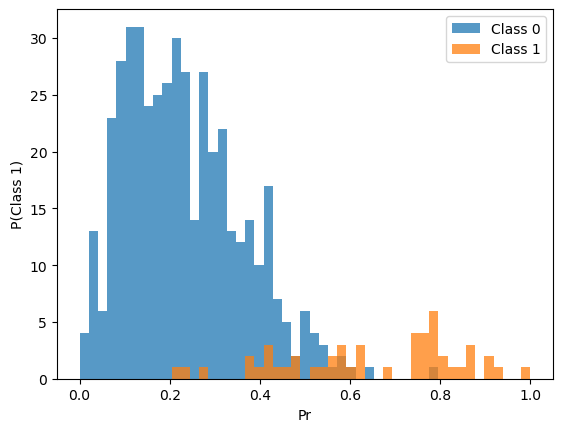

In [5]:
plt.hist(class_data[0]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.hist(class_data[1]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.legend(["Class 0", "Class 1"])
plt.ylabel("P(Class 1)")
plt.xlabel("Pr")
plt.savefig("tst-2-7_7_2.svg")
plt.show()

In [6]:
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.50,
    test_size=N_samples,
    ci_level=0.95,
    use_union_bound=False,
    prediction_method="all",
    n_jobs=-1,
    verbose=True,
    loo_inflation_factor=None,
    use_loo_correction=True
    
)

OPERATIONAL PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 500
  CI level: 95% (Clopper-Pearson)
  PAC guarantee levels:
    Class 0: δ = 0.50 (50% confidence)
    Class 1: δ = 0.50 (50% confidence)
    Union bound: not applied (metrics validated independently)
    Class guarantees: validated separately

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 450
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0998
  PAC risk:           δ = 0.500
  Conformal threshold: 0.4130

  Calibration summary (n = 450)
     Empirical rates on calibration data. Intervals are 95% Clopper-Pearson.
     These do not include PAC guarantees.
     Abstentions:              41 /  450  =  9.11%   95% CI: [0.066, 0.122]
     Singletons:            409 /  450  = 90.89%   95% CI: [0.878, 0.934]
       Correct:             406 /  450  = 90.22%   95% CI: [0.871, 0.928]
       Incorrect:              3 /  450  =  0.67%   95% CI: [0.001, 0.019]
     Error | singleton:  

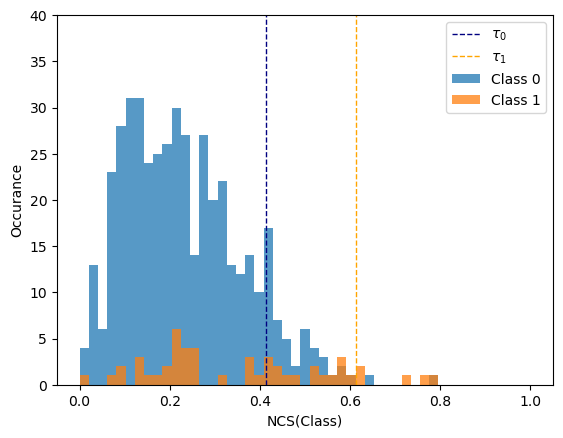

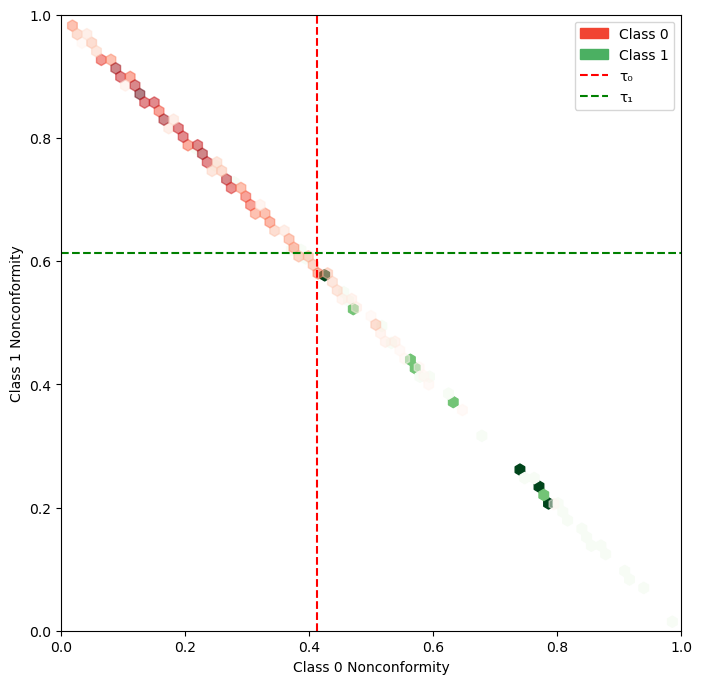

In [7]:
tau_0 = report["calibration_result"][0]["threshold"]
tau_1 = report["calibration_result"][1]["threshold"]
plt.hist(1-class_data[0]["probs"][:, 0], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.hist(1-class_data[1]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.ylabel("Occurance")
plt.xlabel("NCS(Class)")
plt.vlines(tau_0, 0, 40,color='navy', ls="--", lw=1)
plt.vlines(tau_1, 0, 40,color='orange', ls="--", lw=1)
plt.ylim(0,40)
plt.legend([ r"$\tau_0$", r"$\tau_1$", "Class 0", "Class 1"] )
plt.savefig("tst-2-7_7_2.svg")
plt.show()


import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

plt.figure(figsize=(8,8))
h1 = plt.hexbin(1-class_data[1]["probs"][:,0], 1-class_data[1]["probs"][:,1],
                gridsize=50, cmap="Greens", mincnt=1)
h0 = plt.hexbin(1-class_data[0]["probs"][:,0], 1-class_data[0]["probs"][:,1],
                gridsize=50, cmap="Reds", mincnt=1, alpha=0.5)

plt.vlines(tau_0, 0, 1, color="red", linestyle="--")
plt.hlines(tau_1, 0, 1, color="green", linestyle="--")

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Class 0 Nonconformity")
plt.ylabel("Class 1 Nonconformity")

# legend handles
legend_handles = [
    mpatches.Patch(color=plt.cm.Reds(0.6), label="Class 0"),
    mpatches.Patch(color=plt.cm.Greens(0.6), label="Class 1"),
    Line2D([], [], color='red', linestyle='--', label='τ₀'),
    Line2D([], [], color='green', linestyle='--', label='τ₁'),
]

plt.legend(handles=legend_handles, loc="upper right")
#plt.colorbar(h0, label="Density")

plt.show()


In [8]:
validation = ssbc.validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=N_samples,      # Size of each test set
    n_trials=100000,       # Number of independent trials (increase for better stats)
    seed=42,             # For reproducibility
    verbose=True,
    n_jobs=-1,           # Use all CPU cores
)
ssbc.print_validation_results(validation)

Using fixed thresholds: q̂₀=0.4130, q̂₁=0.6128
Running 100000 trials with test_size=500...
Using all available CPU cores for parallel execution
PREDICTION INTERVAL VALIDATION RESULTS
PAC BOUNDS VALIDATION RESULTS

Trials: 100000
Test size: 500
Thresholds: q̂₀=0.4130, q̂₁=0.6128

MARGINAL

SINGLETON:
  Empirical mean: 0.9738
  Expected (LOO): 0.9600
  Quantiles:      [2.5%: 0.958, 5%: 0.962, 25%: 0.970, 50%: 0.974, 75%: 0.978, 95%: 0.984, 97.5%: 0.986]
  Selected bounds: [0.9100, 0.9900]
  Coverage: 99.7% ✅
  Selected coverage: 99.7% ✅
  Mathematical Consistency:
    Event definition: N/A (mixes class distributions)
    k_cal: None, n_cal: 500, n_test: 500
    Denominator alignment: N/A (not a valid Bernoulli event)
      - Global marginal rates cannot be validated as single Bernoulli events
    Overall: ⚠️ Global marginal rates mix classes - no valid Bernoulli event definition ❌
  Method-specific validation:
    Analytical  : [0.9356, 0.9844] (width: 0.0488, coverage: 95.2%) ✅
    Exac

In [ ]:
results1 = ssbc.validate_prediction_interval_calibration(
    simulator=sim,
    n_calibration=N_samples,        # Size of each calibration dataset
    BigN=10000,                  # Number of different calibrations to test
    n_trials=1000,             # Test sets per calibration
    test_size=N_samples,
    ci_level=0.95,
    prediction_method="all",  # Compare all methods
    use_loo_correction=True,
    loo_inflation_factor=1.0,
    verbose=False,            # Minimal printouts
    n_jobs=-1,
    seed=0
)
# Print results


In [ ]:
df1 = ssbc.get_calibration_bounds_dataframe(results1)

In [ ]:
from ssbc import validate_prediction_interval_calibration, get_calibration_bounds_dataframe

In [ ]:
from ssbc import (
    validate_prediction_interval_calibration,
    get_calibration_bounds_dataframe,
    plot_calibration_excess,
)
def plotter(this_df):
    # Plot excess for singleton marginal    
    
    this_df_m_single = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_rate_class0')]
    plot_calibration_excess(this_df_m_single, scope='marginal', metric='singleton_rate_class0', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_single = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_rate_class1')]
    plot_calibration_excess(this_df_m_single, scope='marginal', metric='singleton_rate_class1', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_single_e = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_error_class0')]
    plot_calibration_excess(this_df_m_single_e, scope='marginal', metric='singleton_error_class0', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_single_e = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_error_class1')]
    plot_calibration_excess(this_df_m_single_e, scope='marginal', metric='singleton_error_class1', methods=['analytical', 'exact', 'hoeffding'])

    this_df_m_doublet = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'doublet_rate_class0')]
    plot_calibration_excess(this_df_m_doublet, scope='marginal', metric='doublet_rate_class0', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_abstention = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'doublet_rate_class1')]
    plot_calibration_excess(this_df_m_abstention, scope='marginal', metric='doublet_rate_class1', methods=['analytical', 'exact', 'hoeffding'])


In [ ]:
plotter(df1)

In [ ]:
ssbc.print_calibration_validation_results(results1)